# Case Study of Andy Warhol, Part II: Adding NLP Features
In my previous notebook I developed some good intuition for Warhol's market and for some of the features that correlate with price. However, one glaring omission was the two messy text fields: artwork title and medium. At first it might not seem obvious how these fields would correlate with price, but I have some hypotheses:
- **Keywords found in the title will, in Warhol's case specifically, function as proxies for various bodies of work.** For example, Warhol made Elvis works only briefly, so the keyword `elvis` should help to identify a certain body of work and capture something of that body of work's significance, its scarcity, and its market dynamics. Whereas works related to Marilyn Monroe or Jacqueline Onassis have their own unique date spans and help to identify different bodies of (variously) related work. Essentially I am expecting that title keywords, in Warhol's case, should help cluster similar works together in a way that makes it easier for the algorithm.
- **Title keywords should capture demand for certain types of content.** In addition to helping identify specific bodies of work, I suspet that title keyworks will also make it possible to see patterns in demand for certain kinds of content. In instances where Warhol worked with a similar motif over a long period of time, for example, a title keyword may be less effective at identifying a narrow body of historically related work than identifying subject matter, and perhaps some subject matter is more popular than others (again, not for historical reasons but because of trends in collecting or personal taste, etc).
- **Medium keywords will help parse an otherwise messy feature.** The `medium` feature is particularly knotty, so doing some rudimentary vectorization of its component words should offer a way of grouping things into particular categories. Knowing whether a work was a screenprint or a scrulpture or a polaroid or a drawing will presumably be very important in predicting its market value.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# NLP modules
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Clustering module
from sklearn.cluster import KMeans

In [2]:
# Load data
data = pd.read_csv('data/auction_data_cleaned.csv', index_col=0)

# Parse `auction_date_parsed` as DateTime object
data['auction_date_parsed'] = pd.to_datetime(data['auction_date_parsed'])

# Slice Warhol-specific data with valid sales
warhol = data[(data['artist_name'] == 'Andy Warhol') & (data['price_realized_USD'].notna())].copy()
warhol.head()

,artist_name,title,date,medium,dims,auction_date,auction_house,auction_sale,auction_lot,price_realized,...,auction_year,price_realized_USD_constant_2022,area_cm_sq,volume_cm_cu,living,years_after_death_of_auction,artist_age_at_auction,artist_age_at_artwork_completion,artwork_age_at_auction,years_ago_of_auction
2013,Andy Warhol,The Shadow,1981,unique screenprint on Lenox Museum Board,96.5 x 96.5 cm,"Dec 14, 2022",Christie's,First Open | Post-War & Contemporary Art,Lot19,"US\$52,920",...,2022,52920.0,9312.25,NaN,0,35.0,NaN,53.0,41.0,1
2014,Andy Warhol,Nervous System,1985,synthetic polymer on canvas,50.8 x 58.4 cm,"Dec 14, 2022",Christie's,First Open | Post-War & Contemporary Art,Lot39,"US\$40,320",...,2022,40320.0,2966.72,NaN,0,35.0,NaN,57.0,37.0,1
2015,Andy Warhol,Portrait of Anselmino,1974,Acrylic and silkscreen on canvas,101.5 x 101.5 cm,"Dec 9, 2022",Ketterer Kunst,Evening Sale with Collection Hermann Gerlinger,Lot60,"€375,000• US\$395,839",...,2022,395839.0,10302.25,NaN,0,35.0,NaN,46.0,48.0,1
2016,Andy Warhol,Vanishing Animals: Okapi,1986,synthetic polymer paint on paper,59.2 x 80 cm (23 1/4 x 31 1/2 in.),"Dec 8, 2022",Phillips• London,New Now,Lot100,"£15,120• US\$18,498",...,2022,18498.0,4736.00,NaN,0,35.0,NaN,58.0,36.0,1
2018,Andy Warhol,Mrs. Buch and Yucca,1981,acrylic and silkscreen on canvas,101.6 x 101.9 cm,"Dec 3, 2022",Bonhams,Modern and Contemporary Art,Lot20,"HK\$2,100,000• US\$269,568",...,2022,269568.0,10353.04,NaN,0,35.0,NaN,53.0,41.0,1


In [3]:
# Set style
sns.set_style('white')

# Axis Variables
titlefontsize = 16

# Boxplot Variables
boxprops = {'edgecolor':'black', 'linewidth':1}
whiskerprops = {'color':'black', 'linewidth':1}
medianprops = {'color': 'black', 'linewidth':1}
flierprops = {'marker': 'o', 'markerfacecolor': '#EEEEEE', 'markeredgecolor': 'black', 'alpha':0.6}


# Establish palette
colors = {
    'red': '#FE5F55',
    'blue': '#208AAE',
    'green': '#18A999',
    'yellow': '#F0F3BD',
    'darkblue': '#00072D',
    'purple': '#9368B7',
    'orange': '#F2B880',
    'pink': '#EFC3E6',
    'darkred': '#C44536',
    'darkgreen': '#4B644A',
    'gray': '#DDDDDD',
    'darkgray': '#AAAAAA'
}

colorslist = [c for c in colors.values()]

mypalette = sns.set_palette(sns.color_palette(colorslist), desat=1)
sns.color_palette(colorslist)

[(0.996078431372549, 0.37254901960784315, 0.3333333333333333),
 (0.12549019607843137, 0.5411764705882353, 0.6823529411764706),
 (0.09411764705882353, 0.6627450980392157, 0.6),
 (0.9411764705882353, 0.9529411764705882, 0.7411764705882353),
 (0.0, 0.027450980392156862, 0.17647058823529413),
 (0.5764705882352941, 0.40784313725490196, 0.7176470588235294),
 (0.9490196078431372, 0.7215686274509804, 0.5019607843137255),
 (0.9372549019607843, 0.7647058823529411, 0.9019607843137255),
 (0.7686274509803922, 0.27058823529411763, 0.21176470588235294),
 (0.29411764705882354, 0.39215686274509803, 0.2901960784313726),
 (0.8666666666666667, 0.8666666666666667, 0.8666666666666667),
 (0.6666666666666666, 0.6666666666666666, 0.6666666666666666)]

# Medium
Let's start with medium. To get a rough sense of what we're dealing with here, I'll make a wordcloud.

In [4]:
# Create single string of medium feature
medium_string = ' '.join(warhol['medium'])

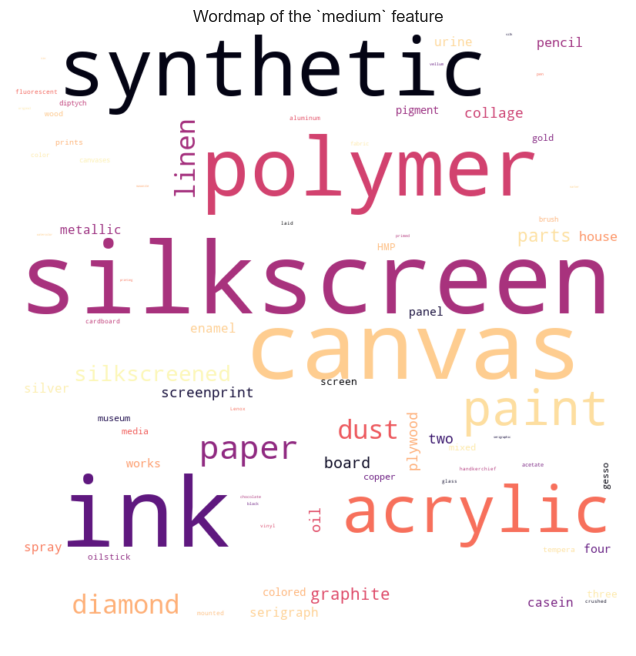

In [5]:
plt.subplots(figsize=(10, 8))

# Generate wordcloud
wc = WordCloud(
    width=800, height=800, background_color='white', colormap='magma', 
    max_words=100, collocations=False, include_numbers=True
).generate(medium_string)

plt.title('Wordmap of the `medium` feature')

# Display
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');

This wordcloud gives us a very quick and dirty sense of what words come up most often in the `medium` feature.

The `WordCloud` object has a `words_` attribute, which is a dictionary of the above word tokens and their associated frequency. It would not be complicated to loop through that list and look at price distributions for titles containing each of those tokens. However, vectorizing this feature using `sklearn.feature_extraction.text.CountVectorizer` will ultimately provide an easier way of doing this.

But before doing that, notice that there are some similar words in the wordcloud: 'silkscreen', 'silkscreened', and 'screenprint', for example. I think it's safe to assume that these are referring to the same thing and should be merged. I considered using a stemmer such as `nltk.stem.snowball.SnowballStemmer` to reduce words to common stems, however this wouldn't capture a discrepancy like 'silkscreen' and 'screenprint.'

New plan:
- I'll do a pass with `sklearn.feature_extraction.text.CountVectorizer` (no stopwords) and get a list of *all* the word tokens found in the `medium` feature
- I'll import these words into OpenRefine, which has some good clustering support to find similar words
- With the results, I'll find and replace old words (e.g., 'screenprint', 'silkscreen', 'silkscreened') with a normalized word ('silkscreen')
- Then, I'll use the `CountVectorizer` on the new, normalized `medium` feature to extract tokens.

In [6]:
# Instantiate CountVectorizer object
countvectorizer = CountVectorizer(
    analyzer='word', 
)

# Fit vectorizer
count_wm = countvectorizer.fit_transform(warhol['medium'].fillna(''))

# Convert to DataFrame
medium_tokens = pd.DataFrame(data=count_wm.toarray(), columns=countvectorizer.get_feature_names_out())

medium_tokens.head()

,10,16,acetate,acrylic,aid,album,aluminum,and,aniline,appliqué,...,watermarked,white,whitman,with,wood,works,wove,wrapped,wrapping,yellow
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Above is what the first pass of the `medium` field looks like: a sparse matrix comprising 250 keyword tokens as feature names and values indicating the occurrence of each token in each work.

Let's have a look at the most frequently-occurring tokens:

In [7]:
# Count up occurrences of each token and preview
tokens_sum = medium_tokens.sum().sort_values(ascending=False)
tokens_sum.head(10)

on            2532
silkscreen    2344
and           2305
canvas        2102
ink           1664
polymer       1524
synthetic     1495
acrylic        933
inks           548
paint          478
dtype: int64

Notice that we're getting keywords that are typically excluded--things like 'on' or 'and'. This is because I decided not to include stop words when instantiating the `CounterVectorizer` object, since 250 is not too many words to review and I didn't want to miss anything important that might have been mistakenly excluded as a stopword.

In [8]:
# Export resulting tokens
pd.DataFrame(medium_tokens.columns, columns=['medium_tokens']).to_csv('data/medium_tokens.csv')

In [9]:
# Import reduced tokens (reduced using OpenRefine)
medium_tokens_reduced = pd.read_csv('data/medium_tokens_reduced.csv', usecols=[1,2])
medium_tokens_reduced.head()

,medium_tokens,medium_tokens_reduced
0,10,10
1,16,16
2,acetate,acetate
3,acrylic,acrylic
4,aid,aid


In [10]:
medium_tokens_reduced[medium_tokens_reduced['medium_tokens'].str.startswith('screen')]

,medium_tokens,medium_tokens_reduced
161,screen,screen
162,screenprint,silkscreen
163,screenprinting,silkscreen


In [11]:
# Create dictionary mapping original medium tokens to reduced tokens
medium_mapper = {}
for row in range(len(medium_tokens_reduced)):
    medium_mapper[medium_tokens_reduced.loc[row, 'medium_tokens']] = medium_tokens_reduced.loc[row, 'medium_tokens_reduced']

warhol['medium_reduced'] = warhol['medium']

for key, value in medium_mapper.items():
    warhol['medium_reduced'] = warhol['medium_reduced'].str.replace(key, value)
    
warhol[['medium', 'medium_reduced']].sample(10)

,medium,medium_reduced
5660,synthetic polymer silkscreen,synthetic polymer silkscreen
2826,silkscreen ink on canvas,silkscreen ink on canvas
2440,synthetic polymer and silkscreen ink on canvas,synthetic polymer and silkscreen ink on canvas
5373,synthetic polymer on canvas,synthetic polymer on canvas
2353,acrylic and silkscreen ink on canvas,acrylic and silkscreen ink on canvas
5072,synthetic polymer and silkscreen inks on canvas,synthetic polymer and silkscreen ink on canvas
2659,acrylic and silkscreen ink on canvas,acrylic and silkscreen ink on canvas
3270,synthetic polymer and silkscreen ink on canvas,synthetic polymer and silkscreen ink on canvas
2439,synthetic polymer and silkscreen ink on canvas,synthetic polymer and silkscreen ink on canvas
4039,other,other


We can already get a rough sense for the way in which the medium feature has been reduced. Now let's tokenize `medium_reduced` and join the result

In [12]:
# Instantiate CountVectorizer object with stopwords
countvectorizer = CountVectorizer(
    analyzer='word',
    stop_words=['on', 'and', 'in', 'with'],
    max_features=50
)

# Fit vectorizer
count_wm = countvectorizer.fit_transform(warhol['medium_reduced'].fillna(''))

# Convert to DataFrame
medium_tokens = (
    pd.
    DataFrame(data=count_wm.toarray(), columns=countvectorizer.get_feature_names_out(), index=warhol.index)
    .add_prefix('mediumtoken_')
)

# Count token and get column names above thresshold
medium_tokens_sum = medium_tokens.sum().sort_values(ascending=False)
medium_tokens_above_thresh = medium_tokens_sum[medium_tokens_sum > 20].index

# Join medium tokens to original DF
warhol = warhol.join(medium_tokens[medium_tokens_above_thresh])
warhol.head()

,artist_name,title,date,medium,dims,auction_date,auction_house,auction_sale,auction_lot,price_realized,...,mediumtoken_two,mediumtoken_collage,mediumtoken_pencil,mediumtoken_house,mediumtoken_serigraph,mediumtoken_color,mediumtoken_urine,mediumtoken_silver,mediumtoken_metallic,mediumtoken_enamel
2013,Andy Warhol,The Shadow,1981,unique screenprint on Lenox Museum Board,96.5 x 96.5 cm,"Dec 14, 2022",Christie's,First Open | Post-War & Contemporary Art,Lot19,"US\$52,920",...,0,0,0,0,0,0,0,0,0,0
2014,Andy Warhol,Nervous System,1985,synthetic polymer on canvas,50.8 x 58.4 cm,"Dec 14, 2022",Christie's,First Open | Post-War & Contemporary Art,Lot39,"US\$40,320",...,0,0,0,0,0,0,0,0,0,0
2015,Andy Warhol,Portrait of Anselmino,1974,Acrylic and silkscreen on canvas,101.5 x 101.5 cm,"Dec 9, 2022",Ketterer Kunst,Evening Sale with Collection Hermann Gerlinger,Lot60,"€375,000• US\$395,839",...,0,0,0,0,0,0,0,0,0,0
2016,Andy Warhol,Vanishing Animals: Okapi,1986,synthetic polymer paint on paper,59.2 x 80 cm (23 1/4 x 31 1/2 in.),"Dec 8, 2022",Phillips• London,New Now,Lot100,"£15,120• US\$18,498",...,0,0,0,0,0,0,0,0,0,0
2018,Andy Warhol,Mrs. Buch and Yucca,1981,acrylic and silkscreen on canvas,101.6 x 101.9 cm,"Dec 3, 2022",Bonhams,Modern and Contemporary Art,Lot20,"HK\$2,100,000• US\$269,568",...,0,0,0,0,0,0,0,0,0,0


In [13]:
# The above is notably messy. Down the road, I'd like to substitute with a preprocessing
# function based on what's below:

'''
import re
from unidecode import unidecode

def preprocess_text(text):
    # remove non-letters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # convert all text to lowercase
    text = text.lower()
    
    # replace accented characters with unaccented equivalents
    text = unidecode(text)
       
    # replace common spelling variations with a single word
    text = re.sub(r'\bscreenprint\b', 'silkscreen', text) # example
    
    # split into words and return as a list
    words = text.split()
    return words

# Assign processed text to `medium` in preparation to pass to CountVecorizer object
medium = warhol['medium'].apply(preprocess_text)
'''

"\nimport re\nfrom unidecode import unidecode\n\ndef preprocess_text(text):\n    # remove non-letters\n    text = re.sub(r'[^a-zA-Z\\s]', '', text)\n    \n    # convert all text to lowercase\n    text = text.lower()\n    \n    # replace accented characters with unaccented equivalents\n    text = unidecode(text)\n       \n    # replace common spelling variations with a single word\n    text = re.sub(r'\x08screenprint\x08', 'silkscreen', text) # example\n    \n    # split into words and return as a list\n    words = text.split()\n    return words\n\n# Assign processed text to `medium` in preparation to pass to CountVecorizer object\nmedium = warhol['medium'].apply(preprocess_text)\n"

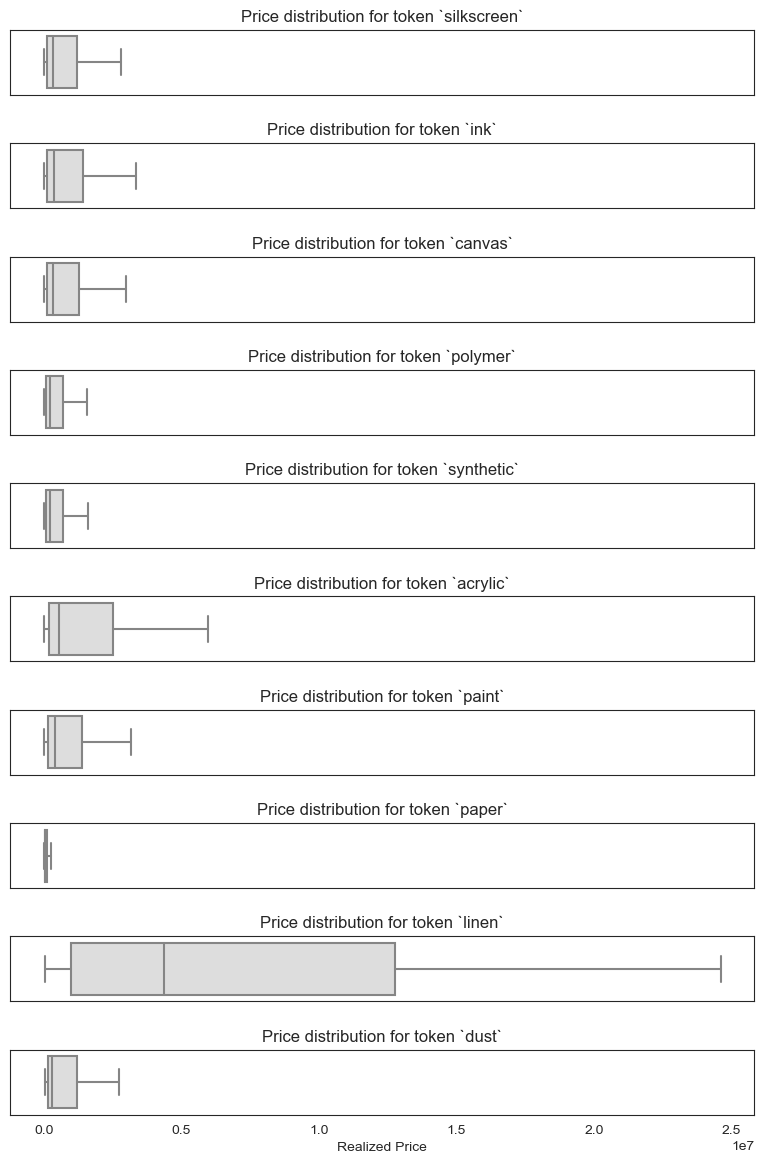

In [14]:
fig, axs = plt.subplots(10, 1, figsize=(8, 12), sharex=True)

for i, col in enumerate(medium_tokens_above_thresh[:10]):
    
    sns.boxplot(
        data=warhol[warhol[col] == 1],
        x='price_realized_USD_constant_2022',
        ax=axs[i],
        showfliers=False,
        color=colors['gray']
    )
    
    axs[i].set_title("Price distribution for token `{}`".format(col[col.find('_') + 1:]))
    axs[i].set_xlabel('')

axs[9].set_xlabel('Realized Price')
fig.tight_layout(pad=2);

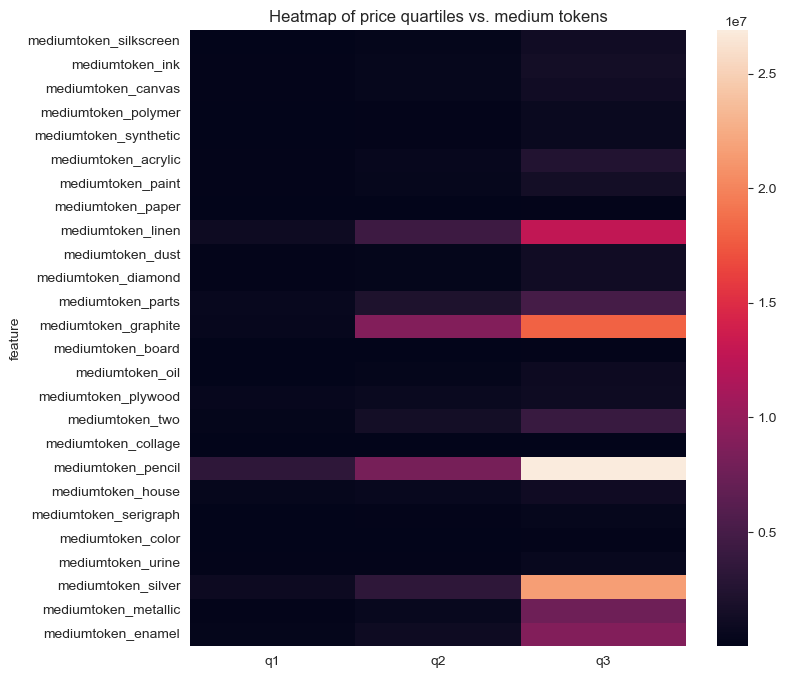

In [15]:
price_quartiles = {
    'feature':[],
    'q1':[],
    'q2':[],
    'q3':[]
}

for col in medium_tokens_above_thresh:
    price_quartiles['feature'].append(col)
    q1, q2, q3 = warhol.loc[warhol[col] > 0, 'price_realized_USD_constant_2022'].quantile([.25, .5, .75]).values
    price_quartiles['q1'].append(q1)
    price_quartiles['q2'].append(q2)
    price_quartiles['q3'].append(q3)

plt.subplots(figsize=(8,8))
sns.heatmap(pd.DataFrame(price_quartiles).set_index('feature'))
plt.title('Heatmap of price quartiles vs. medium tokens');

Interestingly we can see that some features of the `medium` column--namely keywords like 'linen', 'graphite', 'pencil', 'silver', and 'enamel'--are associated with higher prices.

# Engineering Features from `title`

Now we'll do the same series of steps for the `title` feature.

In [16]:
# Create single string of medium feature
title_string = ' '.join(warhol['title'].dropna())

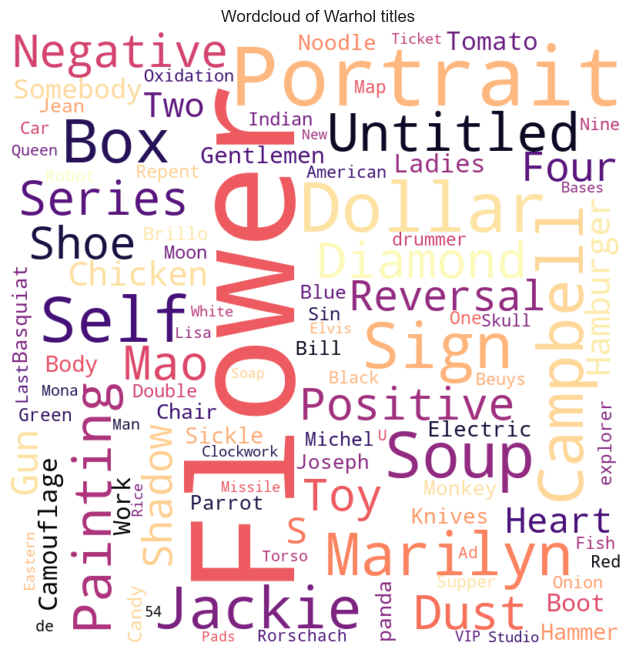

In [17]:
plt.subplots(figsize=(10, 8))

# Generate wordcloud
wc = WordCloud(
    width=800, height=800, background_color='white', colormap='magma', 
    max_words=100, collocations=False, include_numbers=True
).generate(title_string)

plt.title('Wordcloud of Warhol titles')

# Display
plt.imshow(wc, interpolation='bilinear')
plt.axis('off');

As with the `medium` wordcloud, this one gives us a fast sense of what Warhol's titles look like in the context of this dataset.

There's way more variability in the `title` feature than `medium` in terms of the sheer number of words, however. As a result, this time around I am going to use stop words and limit the number of features to 30 and we'll go from there.

In [18]:
# Instantiate CountVectorizer object
countvectorizer = CountVectorizer(
    analyzer='word', 
    max_features=30,
    stop_words=['of', 'and', 'the', 'with']
)

# Fit vectorizer
count_wm = countvectorizer.fit_transform(warhol['title'].fillna(''))

# Convert to DataFrame
title_tokens = (
    pd
    .DataFrame(data=count_wm.toarray(), columns=countvectorizer.get_feature_names_out(), index=warhol.index)
    .add_prefix('title_')
)

title_tokens.head()

,title_box,title_campbell,title_can,title_chicken,title_diamond,title_dollar,title_dust,title_flowers,title_four,title_hamburger,...,title_self,title_series,title_shadow,title_shoes,title_sign,title_somebody,title_soup,title_toy,title_two,title_untitled
2013,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's have a look at the most frequently-occurring tokens:

In [19]:
# Count up occurrences of each token and preview
tokens_sum = title_tokens.sum().sort_values(ascending=False)
tokens_sum

title_flowers      250
title_portrait     203
title_dollar       142
title_soup         118
title_self         115
title_sign         114
title_campbell     114
title_box          105
title_jackie        81
title_untitled      77
title_diamond       70
title_painting      65
title_dust          64
title_series        62
title_mao           60
title_marilyn       60
title_negative      58
title_positive      57
title_toy           55
title_reversal      50
title_four          48
title_shoes         46
title_marilyns      41
title_shadow        39
title_can           39
title_two           36
title_chicken       35
title_somebody      34
title_hamburger     34
title_ladies        31
dtype: int64

In [20]:
# Join new features to existing dataset
warhol = warhol.join(title_tokens)
warhol.head()

,artist_name,title,date,medium,dims,auction_date,auction_house,auction_sale,auction_lot,price_realized,...,title_self,title_series,title_shadow,title_shoes,title_sign,title_somebody,title_soup,title_toy,title_two,title_untitled
2013,Andy Warhol,The Shadow,1981,unique screenprint on Lenox Museum Board,96.5 x 96.5 cm,"Dec 14, 2022",Christie's,First Open | Post-War & Contemporary Art,Lot19,"US\$52,920",...,0,0,1,0,0,0,0,0,0,0
2014,Andy Warhol,Nervous System,1985,synthetic polymer on canvas,50.8 x 58.4 cm,"Dec 14, 2022",Christie's,First Open | Post-War & Contemporary Art,Lot39,"US\$40,320",...,0,0,0,0,0,0,0,0,0,0
2015,Andy Warhol,Portrait of Anselmino,1974,Acrylic and silkscreen on canvas,101.5 x 101.5 cm,"Dec 9, 2022",Ketterer Kunst,Evening Sale with Collection Hermann Gerlinger,Lot60,"€375,000• US\$395,839",...,0,0,0,0,0,0,0,0,0,0
2016,Andy Warhol,Vanishing Animals: Okapi,1986,synthetic polymer paint on paper,59.2 x 80 cm (23 1/4 x 31 1/2 in.),"Dec 8, 2022",Phillips• London,New Now,Lot100,"£15,120• US\$18,498",...,0,0,0,0,0,0,0,0,0,0
2018,Andy Warhol,Mrs. Buch and Yucca,1981,acrylic and silkscreen on canvas,101.6 x 101.9 cm,"Dec 3, 2022",Bonhams,Modern and Contemporary Art,Lot20,"HK\$2,100,000• US\$269,568",...,0,0,0,0,0,0,0,0,0,0


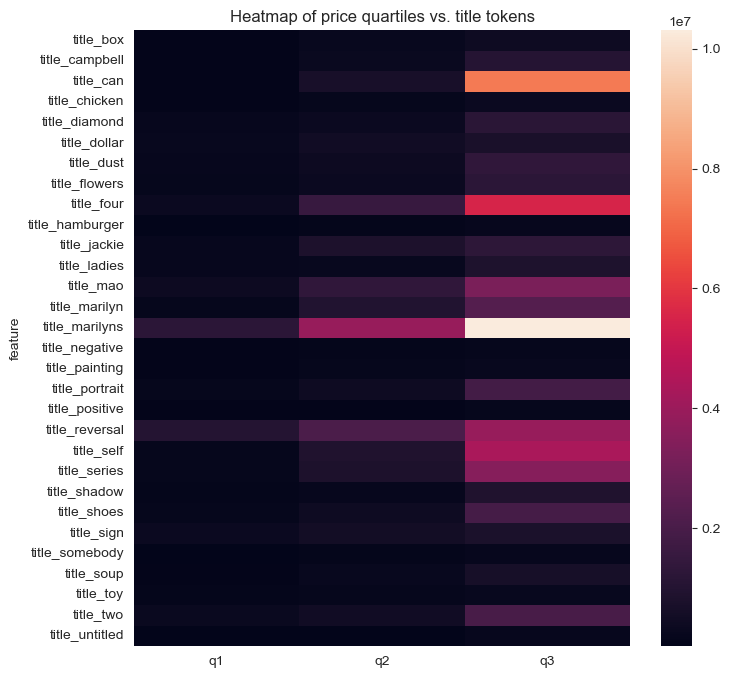

In [21]:
price_quartiles = {
    'feature':[],
    'q1':[],
    'q2':[],
    'q3':[]
}

for col in title_tokens.columns:
    price_quartiles['feature'].append(col)
    q1, q2, q3 = warhol.loc[warhol[col] > 0, 'price_realized_USD_constant_2022'].quantile([.25, .5, .75]).values
    price_quartiles['q1'].append(q1)
    price_quartiles['q2'].append(q2)
    price_quartiles['q3'].append(q3)

plt.subplots(figsize=(8,8))
plt.title('Heatmap of price quartiles vs. title tokens')
sns.heatmap(pd.DataFrame(price_quartiles).set_index('feature'));

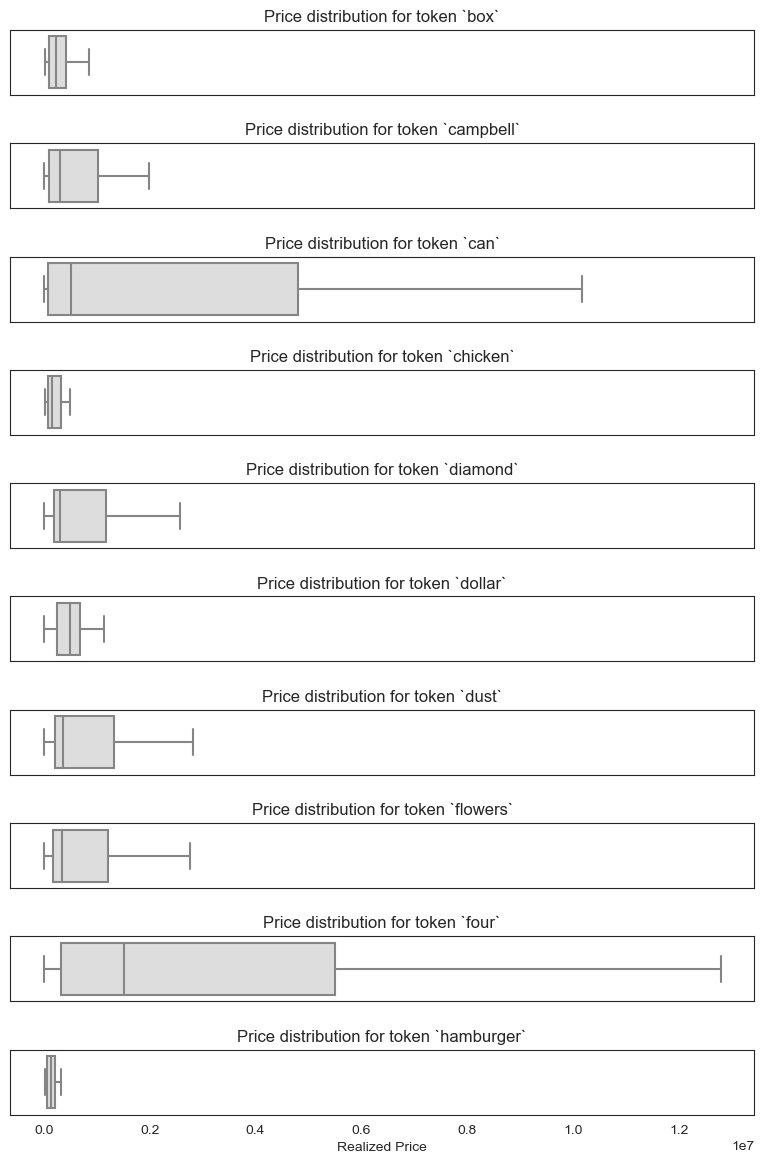

In [22]:
fig, axs = plt.subplots(10, 1, figsize=(8, 12), sharex=True)

for i, col in enumerate(title_tokens.columns[:10]):
    
    sns.boxplot(
        data=warhol[warhol[col] == 1],
        x='price_realized_USD_constant_2022',
        ax=axs[i],
        showfliers=False,
        color=colors['gray']
    )
    
    axs[i].set_title("Price distribution for token `{}`".format(col[col.find('_') + 1:]))
    axs[i].set_xlabel('')

axs[9].set_xlabel('Realized Price')
fig.tight_layout(pad=2);

Even more so than with the `medium` feature, realized prices seem to vary significantly by `title` tokens--makes sense.

Now time to explort this dataframe in preparation for modeling.

In [23]:
warhol.to_csv('data/warhol.csv')